In [1]:
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import gurobipy as gp
from gurobipy import GRB
import cvxpy as cp

In [2]:
full_data = pd.read_csv("yellow_tripdata_2010-01.csv")
full_data['pickup_datetime'] = pd.to_datetime(full_data['pickup_datetime'])
full_data['dropoff_datetime'] = pd.to_datetime(full_data['dropoff_datetime'])

year = 2010
month = 1
day = 21
date = datetime.date(year, month, day)
midnight = datetime.datetime(year, month, day, 0, 0)

day_data = full_data.loc[(full_data['pickup_datetime'].dt.date == date) & (full_data['dropoff_datetime'].dt.date == date)]
day_data = day_data[['pickup_datetime', 'dropoff_datetime', 'trip_distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'fare_amount', 'surcharge', 'mta_tax', 'tip_amount', 'tolls_amount', 'total_amount']]
day_data = day_data.loc[(day_data['pickup_longitude'] != 0) & (day_data['pickup_latitude'] != 0)]

n = 50
data = day_data.sample(n).sort_values(by = 'pickup_datetime')
data.index = range(n)
data

C:\Users\holly\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,pickup_datetime,dropoff_datetime,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,2010-01-21 00:04:27,2010-01-21 00:18:23,3.80,-73.991127,40.750415,-73.952802,40.789250,11.7,0.5,0.5,0.00,0.00,12.70
1,2010-01-21 00:42:21,2010-01-21 00:57:19,2.30,-73.996520,40.737172,-73.995193,40.721563,9.7,0.5,0.5,0.90,0.00,11.60
2,2010-01-21 02:37:00,2010-01-21 02:54:00,6.03,-74.008247,40.703918,-73.960875,40.777550,16.1,0.5,0.5,0.00,0.00,17.10
3,2010-01-21 04:50:03,2010-01-21 05:01:23,4.50,-73.990649,40.756126,-73.930743,40.759170,12.5,0.5,0.5,2.70,0.00,16.20
4,2010-01-21 06:35:44,2010-01-21 06:42:34,2.40,-73.975966,40.782159,-73.997514,40.753029,7.7,0.0,0.5,0.00,0.00,8.20
5,2010-01-21 06:45:58,2010-01-21 06:56:27,2.70,-73.999745,40.717928,-73.991178,40.750426,8.9,0.0,0.5,0.00,0.00,9.40
6,2010-01-21 07:17:34,2010-01-21 07:27:34,3.30,-73.991336,40.750047,-74.014963,40.711179,9.7,0.0,0.5,0.00,0.00,10.20
7,2010-01-21 07:19:26,2010-01-21 07:29:42,1.30,-73.968685,40.764389,-73.977887,40.753305,6.9,0.0,0.5,0.00,0.00,7.40
8,2010-01-21 07:53:00,2010-01-21 08:19:00,8.54,-73.959163,40.777707,-74.009373,40.708520,22.1,0.0,0.5,2.00,0.00,24.60
9,2010-01-21 08:11:00,2010-01-21 08:40:00,3.91,-73.987008,40.737267,-73.972177,40.760220,16.5,0.0,0.5,0.00,0.00,17.00


In [3]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 3956
    return c * r

In [19]:
t = 2                # Number of taxis
taxi_lon = -73.9772  # Initial longitude of taxis
taxi_lat = 40.7527   # Initial latitude of taxis
mph = 20             # Taxi speed between passengers
driving_cost = .6    # in dollars per mile
time_window = timedelta(hours = .05)     # time window in hours

dist_between = np.zeros((n+t, n))    # Distance between dropoff & pickup of passenger-pair (i,j)
                                     # Note: =0 where i==j
possible = np.zeros((n+t, n+t))      # =1 if connection (i,j) is possible, =0 if impossible
profit_accept = np.zeros((n+t, n))   # Net profit from accepting passenger j (based on preceding passenger i)
                                     # Note: =0 if connection (i,j) is impossible
    
for i in range(n):
    for j in range(n):
        if (i == j): continue
        
        dist_between[i,j] = haversine(data.loc[i,'dropoff_longitude'], data.loc[i, 'dropoff_latitude'],
                                      data.loc[j, 'pickup_longitude'], data.loc[j, 'pickup_latitude'])
        time_between = timedelta(hours = dist_between[i,j] / mph)
        if (data.loc[i, 'dropoff_datetime'] + time_between > data.loc[j, 'pickup_datetime'] + time_window): continue
        else: possible[i,j] = 1
        profit_accept[i,j] = data.loc[j, 'total_amount'] - driving_cost * (dist_between[i,j] + data.loc[j, 'trip_distance'])
        
for k in range(n, n+t):
    for j in range(n):
        
        dist_between[k,j] = haversine(taxi_lon, taxi_lat, data.loc[j, 'pickup_longitude'], data.loc[j, 'pickup_latitude'])
        time_between = timedelta(hours = dist_between[k,j] / mph)
        if (midnight + time_between > data.loc[j, 'pickup_datetime'] + time_window): continue
        else: possible[k,j] = 1
        profit_accept[k,j] = data.loc[j, 'total_amount'] - driving_cost * (dist_between[k,j] + data.loc[j, 'trip_distance'])

In [20]:
s_list = []
p_list = []

for i in range(n+t):
    
    successors = []
    predecessors = []
    
    for j in range(n+t):
        if (possible[i,j] == 1): successors.append(j)
        if (possible[j,i] == 1): predecessors.append(j)
            
    s_list.append(successors)
    p_list.append(predecessors)

In [21]:
def T(i,j):
    if (i == j): return 0
    if (i >= n):
        dist_between[i,j] = haversine(taxi_lon, taxi_lat, data.loc[j, 'pickup_longitude'], data.loc[j, 'pickup_latitude'])
        output = timedelta(hours = dist_between[i,j] / mph)        
    else:
        dist_between[i,j] = haversine(data.loc[i,'dropoff_longitude'], data.loc[i, 'dropoff_latitude'],
                                  data.loc[j, 'pickup_longitude'], data.loc[j, 'pickup_latitude'])
        time_between = timedelta(hours = dist_between[i,j] / mph)
        output = data.loc[i, 'dropoff_datetime'] - data.loc[i, 'pickup_datetime'] + time_between
    return output.total_seconds() / 60

def to_minutes(td):
    return td.total_seconds() / 60

In [28]:
# Gurobi

# y[k,i] = 1 if customer i is picked-up by taxi k as a first customer
# y[k,i] = 0 otherwise

# x[i,j] = 1 if customer j is picked-up immediately after customer i by a taxi
# x[i,j] = 0 otherwise

# p[i] = 1 if customer i is picked-up by a taxi
# p[i] = 0 otherwise

# Create optimization model
m = gp.Model('netflow')

# Create variables
p = {}
x = {}
time = {}
time_min = {}
time_max = {}
for i in range(n):
    p[i] = m.addVar(vtype=GRB.BINARY)
    time[i] = m.addVar()
    time_min[i] = to_minutes(data.loc[i, 'pickup_datetime'] - midnight)
    time_max[i] = to_minutes(data.loc[i, 'pickup_datetime'] - midnight + time_window)
for i in range(n+t):
    for j in s_list[i]:
        x[i,j] = m.addVar(vtype=GRB.BINARY)
        
# Set objective
m.setObjective(gp.quicksum(profit_accept[i,j] * x[i,j] for i in range(n+t) for j in s_list[i]), GRB.MAXIMIZE)

# Add constraints
m.addConstrs(
    gp.quicksum(x[i,j] for i in p_list[j]) == p[j]
        for j in range(n))

m.addConstrs(
    gp.quicksum(x[i,j] for j in s_list[i]) <= p[i]
        for i in range(n))

m.addConstrs(
    gp.quicksum(x[k,j] for j in s_list[k]) <= 1
        for k in range(n, n+t))

m.addConstrs(
    time_min[i] <= time[i]
        for i in range(n))

m.addConstrs(
    time[i] <= time_max[i]
        for i in range(n))

m.addConstrs(
    time[j] - time[i] >= (time_min[j] - time_max[i]) + (T(i,j) - (time_min[j] - time_max[i])) * x[i,j]
        for i in range(n) for j in s_list[i])

m.addConstrs(
    time[j] >= time_min[j] + (T(k,j) - time_min[j]) * x[k,j]
        for k in range(n, n+t) for j in s_list[k])

# Compute optimal solution
m.optimize()

# Print solution
if m.status == GRB.OPTIMAL:
    #for v in m.getVars():
        #print(v.varName, v.x)
    print('Obj:', m.objVal)
    
x[i, j].X

Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (win64)
Optimize a model with 1485 rows, 1383 columns and 6517 nonzeros
Model fingerprint: 0x0252012d
Variable types: 50 continuous, 1333 integer (1333 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [3e-02, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Found heuristic solution: objective -0.0000000
Presolve removed 1386 rows and 102 columns
Presolve time: 0.01s
Presolved: 99 rows, 1281 columns, 2562 nonzeros
Variable types: 0 continuous, 1281 integer (1281 binary)

Root relaxation: objective 4.769012e+02, 245 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     476.9012464  476.90125  0.00%     -    0s

Explored 0 nodes (245 simplex iterations) in 0.04 seconds
Thread count was 8 (of 8 available processors)

Solution cou

-0.0

In [29]:
# Cvxpy

# Create variables
p = {}
x = {}
time = {}
time_min = {}
time_max = {}
for i in range(n):
    p[i] = cp.Variable(boolean = True)
    time[i] = cp.Variable()
    time_min[i] = to_minutes(data.loc[i, 'pickup_datetime'] - midnight)
    time_max[i] = to_minutes(data.loc[i, 'pickup_datetime'] - midnight + timedelta(hours = .1))
for i in range(n+t):
    for j in s_list[i]:
        x[i,j] = cp.Variable(boolean = True)

constraints = []
constraints += [cp.sum([x[i,j] for i in p_list[j]]) == p[j] for j in range(n)]
constraints += [cp.sum([x[i,j] for j in s_list[i]]) <= p[i] for i in range(n)]
constraints += [cp.sum([x[k,j] for j in s_list[k]]) <= 1 for k in range(n, n+t)]
constraints += [time_min[i] <= time[i] for i in range(n)]
constraints += [time[i] <= time_max[i] for i in range(n)]
constraints += [time[j] - time[i] >= (time_min[j] - time_max[i]) + (T(i,j) - (time_min[j] - time_max[i])) * x[i,j]
                for i in range(n) for j in s_list[i]]
constraints += [time[j] >= time_min[j] + (T(k,j) - time_min[j]) * x[k,j]
                for k in range(n, n+t) for j in s_list[k]]

profit = cp.sum([profit_accept[i,j] * x[i,j] for i in range(n+t) for j in s_list[i]])
objective = cp.Maximize(profit)
problem = cp.Problem(objective, constraints)
problem.solve()
x[i, j].value

# x_val = scipy.sparse.coo_matrix(shape(n+t, n+t))
# for i in range(n+t):
#     for j in s_list[i]:
#         x_val[i,j] = x[i, j].value

array(-0.)

In [30]:
import scipy.sparse as spa
x_val = spa.dok_matrix((n+t, n+t))
for i in range(n+t):
    for j in s_list[i]:
        x_val[i,j] = x[i, j].value
print(x_val.tocoo())
print(objective.value)

  (1, 2)	1.0
  (2, 4)	1.0
  (3, 5)	1.0
  (4, 7)	1.0
  (5, 6)	1.0
  (6, 9)	1.0
  (7, 8)	1.0
  (8, 11)	1.0
  (9, 10)	1.0
  (10, 12)	1.0
  (11, 13)	1.0
  (12, 14)	1.0
  (13, 15)	1.0
  (14, 20)	1.0
  (15, 16)	1.0
  (16, 17)	1.0
  (17, 19)	1.0
  (19, 21)	1.0
  (20, 22)	1.0
  (21, 28)	1.0
  (22, 24)	1.0
  (24, 25)	1.0
  (25, 27)	1.0
  (27, 29)	1.0
  (28, 30)	1.0
  (29, 35)	1.0
  (30, 33)	1.0
  (33, 36)	1.0
  (35, 37)	1.0
  (36, 38)	1.0
  (37, 39)	1.0
  (38, 41)	1.0
  (39, 40)	1.0
  (40, 43)	1.0
  (41, 42)	1.0
  (43, 45)	1.0
  (45, 46)	1.0
  (46, 47)	1.0
  (47, 48)	1.0
  (48, 49)	1.0
  (50, 3)	1.0
  (51, 1)	1.0
476.9012464149477


In [31]:
arcs = np.asarray(np.nonzero(x_val))
# locs = np.unique(arcs[arcs < 200])
# lons = data.iloc[locs, 3]
# lats = data.iloc[locs, 4]
# lons = data.iloc[:, 3]
# lats = data.iloc[:, 4]

loc_origin = arcs[0][:-t]
loc_destin = arcs[1][:-t]
r = len(loc_origin)

lon_origin = data.iloc[loc_origin, 3].to_numpy()
lat_origin = data.iloc[loc_origin, 4].to_numpy()
lon_destin = data.iloc[loc_destin, 3].to_numpy()
lat_destin = data.iloc[loc_destin, 4].to_numpy()

In [32]:
def plot_coords(ax, ob):
    x, y = ob.xy
    ax.plot(x, y, 'o', color='#999999', zorder=1)

def plot_bounds(ax, ob):
    x, y = zip(*list((p.x, p.y) for p in ob.boundary))
    ax.plot(x, y, 'o', color='#000000', zorder=1)

def plot_line(ax, ob):
    x, y = ob.xy
    ax.plot(x, y, color='green', linewidth=1, solid_capstyle='round', zorder=2)

C:\Users\holly\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\holly\Anaconda3\lib\site-packages\contextily\tile.py:629: UserWarning: The inferred zoom level of 28 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)


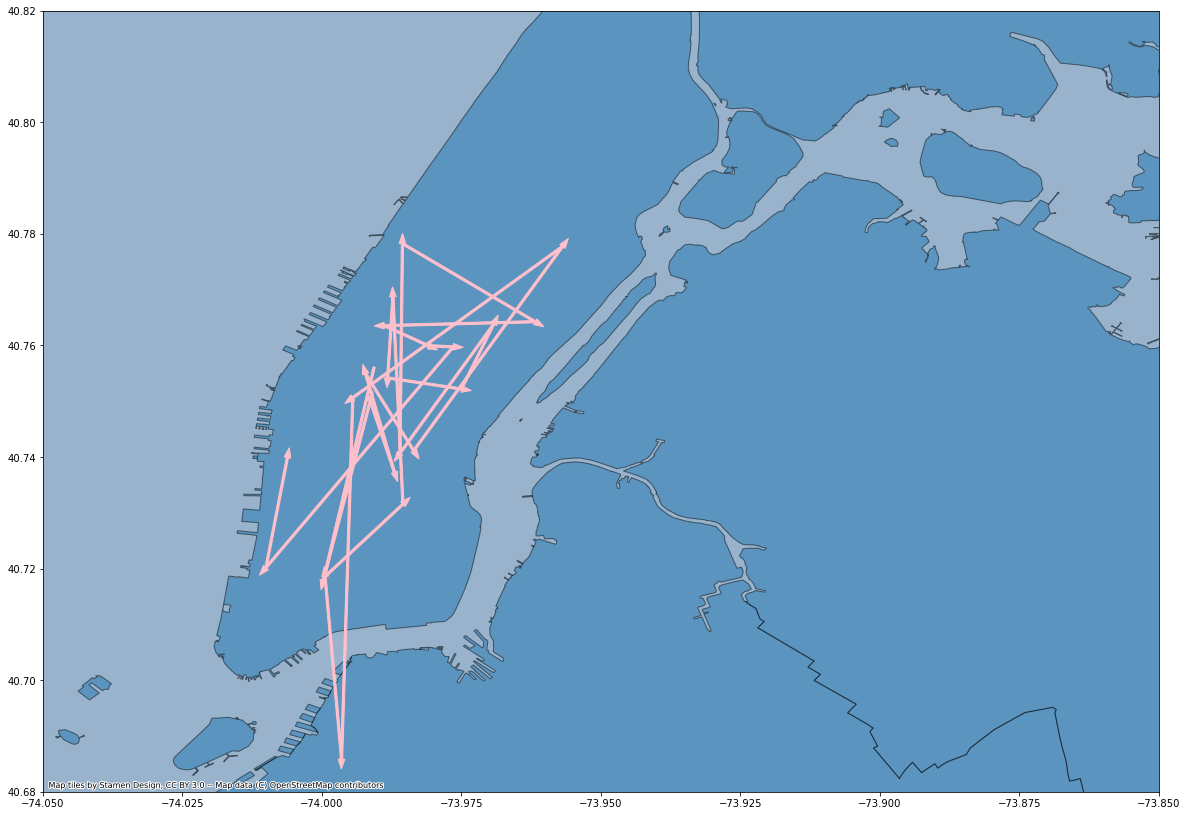

<Figure size 432x288 with 0 Axes>

In [33]:
# from shapely.geometry import Point, LineString
from matplotlib.patches import FancyArrowPatch

nyc = gpd.read_file(gpd.datasets.get_path('nybb'))
# nyc = nyc.to_crs(epsg=3857)
nyc = nyc.to_crs(epsg=4326)
ax = nyc.plot(figsize=(20, 20), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax)

ax.set_xlim(-74.05, -73.85)
ax.set_ylim(40.68, 40.82)

# nodes = gpd.GeoDataFrame(geometry=gpd.points_from_xy(lons, lats))
# nodes.plot(color='green')

fig = plt.figure()

# All Taxis' Journeys
# for i in range(r):
#     dx = lon_destin[i] - lon_origin[i]
#     dy = lat_destin[i] - lat_origin[i]
#     ax.arrow(lon_origin[i], lat_origin[i], dx, dy, color = 'pink', width=.0005)
#     # line = LineString([(lon_origin[i], lat_origin[i]), (lon_destin[i], lat_destin[i])])
#     # plot_coords(ax, line)
#     # plot_bounds(ax, line)
#     # plot_line(ax, line)

# One Taxi's Journey
taxi_num = n + 0
node = arcs[1][np.where(arcs[0] == taxi_num)] # First node (rider) for given taxi
while True:
    where = np.array(np.where(loc_origin == node))
    if (where.size == 0): break
    i = where[0][0]
    dx = lon_destin[i] - lon_origin[i]
    dy = lat_destin[i] - lat_origin[i]
    ax.arrow(lon_origin[i], lat_origin[i], dx, dy, color = 'pink', width=.0004)
    node = loc_destin[i]
    # line = LineString([(lon_origin[i], lat_origin[i]), (lon_destin[i], lat_destin[i])])
    # plot_coords(ax, line)
    # plot_bounds(ax, line)
    # plot_line(ax, line)

plt.show()

In [ ]:
# locations = gpd.read_file('taxi_zones.shp')
# print(locations.crs)
# locations = locations.to_crs({'init': 'epsg:4326'})

# fig, ax = plt.subplots(figsize = (10,10))
# locations.plot(ax=ax)
# plt.show()

# def x_coord(i):
#     return locations.iloc[i,6].centroid.x
# def y_coord(i):
#     return locations.iloc[i,6].centroid.y